# **Strain Gage Calculations - v5**

- All the required input files should be in the same directory as this notebook
- Output files are generated in the same directory as well.

--------
### **Import Libraries**

In [1]:
# region Import libraries

import pandas as pd
import numpy as np
import re
import endaq
import plotly.express as px
from openpyxl import load_workbook
import xlsxwriter
# import sys
# from PyQt5.QtWidgets import QApplication, QFileDialog
import plotly.graph_objs as go
from scipy.interpolate import interp1d
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, Dropdown, VBox, HBox, Tab, Button
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# endregion

C:\Users\emre_\AppData\Local\Temp\ipykernel_34752\2736589563.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


--------
### **References** 

<u>The formulas used are based on below references</u>: 

https://community.sw.siemens.com/s/article/rosette-strain-gauges

https://www.youtube.com/watch?v=9x-3H74a8YQ

https://amesweb.info/Stress-Strain/Strain-Gauge-Rosette-Calculation-Example.aspx


In [2]:
# region Engineering Formulas
def transform_strains_to_global(epsilon_A, epsilon_B, epsilon_C, angles):
    """
    Transform strains from the rosette's local coordinate system to the global coordinate system.

    Parameters:
    - epsilon_A (float): Measured normal strain from the first strain gauge in the rosette.
    - epsilon_B (float): Measured normal strain from the second strain gauge in the rosette.
    - epsilon_C (float): Measured normal strain from the third strain gauge in the rosette.
    - angles (list of float): The angles (in degrees) of the strain gauges relative to the global x-axis.

    Returns:
    - numpy.array: The transformed strains in the global coordinate system, containing
      the normal strains epsilon_x and epsilon_y, along with the engineering shear strain gamma_xy.
    """
    theta_A, theta_B, theta_C = np.radians(angles)
    T = np.array([
        [np.cos(theta_A)**2, np.sin(theta_A)**2, 1 * np.sin(theta_A) * np.cos(theta_A)],
        [np.cos(theta_B)**2, np.sin(theta_B)**2, 1 * np.sin(theta_B) * np.cos(theta_B)],
        [np.cos(theta_C)**2, np.sin(theta_C)**2, 1 * np.sin(theta_C) * np.cos(theta_C)]
    ])
    T_inv = np.linalg.inv(T)
    local_strains = np.array([epsilon_A, epsilon_B, epsilon_C])
    global_strains = T_inv @ local_strains
    return global_strains

def calculate_principal_strains(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the principal strains using Mohr's circle relations.

    Parameters:
    - epsilon_x (float): Normal strain in the x-direction (global coordinate system).
    - epsilon_y (float): Normal strain in the y-direction (global coordinate system).
    - gamma_xy (float): Engineering shear strain in the global coordinate system.

    Returns:
    - numpy.array: An array containing the maximum (epsilon_1) and minimum (epsilon_2)
      principal strains. These values are critical for assessing the material's behavior
      under stress and for failure analysis.

    Note:
    - The shear strain input should be in engineering terms (total angular deformation),
      as this is the standard output from strain gauges.
    """
    C = (epsilon_x + epsilon_y) / 2
    R = np.sqrt(((epsilon_x - epsilon_y) / 2)**2 + (gamma_xy / 2)**2)
    epsilon_1 = C + R  # Maximum principal strain
    epsilon_2 = C - R  # Minimum principal strain
    return np.array([epsilon_1, epsilon_2])

def calculate_principal_stresses(principal_strains, E, v):
    """
    Calculate the principal stresses from the principal strains using material properties.

    Given the principal strains, this function applies Hooke's law in two dimensions to
    compute the principal stresses. The material's Young's modulus (E) and Poisson's ratio (v)
    are used to relate the strains to the stresses. This function assumes a linear elastic
    material behavior and plane stress conditions, which is a common scenario in thin structures
    where one dimension is significantly smaller than the other two.

    Parameters:
    - principal_strains (numpy.array): An array of the principal strains [epsilon_1, epsilon_2].
    - E (float): Young's Modulus of the material in Pascals (Pa).
    - v (float): Poisson's ratio of the material, dimensionless.

    Returns:
    - numpy.array: An array containing the principal stresses [sigma_1, sigma_2] in Pascals (Pa).
      These stresses are the maximum and minimum normal stresses that occur at the principal
      strain orientations, where the shear stress is zero.

    Note:
    - The principal strains should be provided in microstrains (με) for the calculation.
    - The function returns the principal stresses in Pascals (Pa), but they are manually
      converted to other MPa (MegaPascals) at the function return (by a /1e6 division).
    - The function holds true for isotropic materials where the stress-strain relationship 
      is governed by the isotropic form of Hooke's law.
    """
    #S = np.array([
    #    [1, v, 0],
    #    [v, 1, 0],
    #    [0, 0, (1-v)/2]
    #]) * E / (1 - v**2)
    S = np.array([
        [1, v],
        [v, 1]
    ]) * E / (1 - v**2)

    principal_stresses = S @ (principal_strains /1e6)
    return principal_stresses / 1e6  # Convert Pa to MPa

def calculate_principal_strain_orientation(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the orientation of the principal strains from the original strain measurements using Mohr's circle analysis.
    Parameters:
    - epsilon_x (float): Normal strain in the x-direction.
    - epsilon_y (float): Normal strain in the y-direction.
    - gamma_xy (float): Engineering shear strain.
    Returns:
    - theta_p (float): Angle of the principal strain in degrees.
    """
    # Calculate the angle to the maximum principal strain
    theta_p_rad = 0.5 * np.arctan2(gamma_xy, epsilon_x - epsilon_y)
    theta_p = np.degrees(theta_p_rad)

    # Adjust the angle to ensure it's within the 0-180 degree range
    if theta_p < 0:
        theta_p += 180

    return theta_p

def calculate_biaxiality_ratio(S1, S2):
    """
    Calculate the biaxiality ratio from the principal stresses.

    The biaxiality ratio is the ratio of the second principal stress to the first principal stress.
    It is a dimensionless number that indicates the relation between the principal stresses. A
    biaxiality ratio of 1 indicates equal biaxial stress state, while a value of 0 indicates a uniaxial
    stress state. Negative values indicate that the principal stresses are of opposite signs.

    Parameters:
    - S1 (float or numpy.array): First principal stress (assumed to be the larger one in absolute value).
    - S2 (float or numpy.array): Second principal stress (assumed to be the smaller one in absolute value).

    Returns:
    - float or numpy.array: The biaxiality ratio, a dimensionless quantity indicating the biaxial state of stress.

    Note:
    - The function assumes that S1 and S2 are provided such that the absolute value of S1 is
      greater than or equal to the absolute value of S2. If this is not the case, the inputs
      should be swapped.
    """
    # Ensure that sigma_1 is the larger one in absolute terms
    sigma_1 = np.where(np.abs(S1) >= np.abs(S2), S1, S2)
    sigma_2 = np.where(np.abs(S1) >= np.abs(S2), S2, S1)
    
    # Calculate the biaxiality ratio
    biaxiality_ratio = sigma_2 / sigma_1
    
    return biaxiality_ratio

def calculate_von_mises_stress(S1, S2, S3=0):
    """
    Calculate the von Mises stress from the principal stresses.
    
    Parameters:
    S1 (float): First principal stress in MPa.
    S2 (float): Second principal stress in MPa.
    S3 (float): Third principal stress in MPa, assumed to be zero for plane stress condition.
    
    Returns:
    float: The von Mises stress in MPa.
    """
    # Calculate the von Mises stress using the principal stresses
    sigma_vm = np.sqrt(((S1 - S2)**2 + (S1 - S3)**2 + (S2 - S3)**2) / 2)
    return sigma_vm
# endregion

---
## **Inputs**

### **Define Material Properties**

* **E**: Young's Modulus [Pa]

* **v**: Poisson's ratio

In [3]:
E = 200e9  
v = 0.3  

-------

### **Load Input Files**



>**"Name of any FEA data file here".csv**
* Specifies the input CSV data for FEA

    - First column should be time in seconds
    
    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Each rosette channel should be named as ***SG1_1, SG1_2, SG1_3, SG2_1*** etc.

    - Example format:

        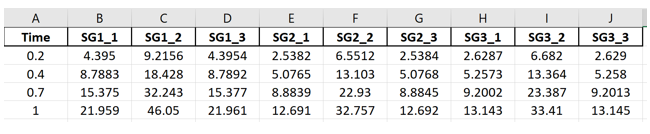
    

>**"Name of any test data file here".csv**
* Specifies the input CSV data for physical tests

    - First column should be time in seconds

    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Each rosette channel should be named as ***SG1_1, SG1_2, SG1_3, SG2_1*** etc.

    - Data should be exported such that it has the following format as a CSV file (see below)

    - Example format:

        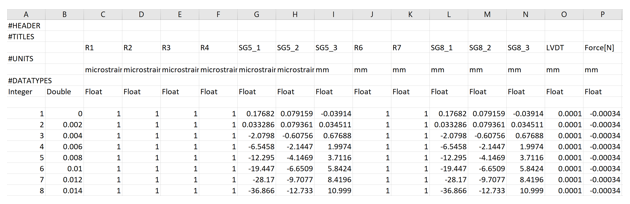


    - It can also be in the format of the FEA results (see the previous image)


>**"Name of SG vs. rosette angle [°] file here".csv**
* Specifies the angles of each channel of a rosette with respect to their preferred axis

    - First column should be the channel name of rosette (SG1_1, SG2 etc.)

    - Remaining columns should be angles in degrees wrt to preferred axis

    - Example format:

        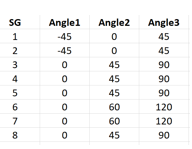

In [4]:
# region Selecting the files through a dialog box
import sys
from PyQt5.QtWidgets import QApplication, QFileDialog

# Initialize the application
app = QApplication(sys.argv)

# File selection for FEA data
file_path_FEA, _ = QFileDialog().getOpenFileName(None, 'Open FEA raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# Check if a file was selected for FEA data
if file_path_FEA:
    print("Selected FEA data:", file_path_FEA)
else:
    print("No FEA data file selected.")
    # Handle the case when no file is selected, or set file_path to a default value
    # file_path = 'default_FEA_data.csv'


# File selection for raw test data of strain gauge rosettes
file_path_measured, _ = QFileDialog().getOpenFileName(None, 'Open test raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# Check if a file was selected for test data
if file_path_measured:
    print("Selected test data:", file_path_measured)
else:
    print("No test data file selected.")
    # Handle the case when no file is selected, or set file_path to a default value
    # file_path = 'default_test_data.csv'


# File selection for rosette angles data
angles_file_path, _ = QFileDialog().getOpenFileName(None, 'Open File', '', 'All Files (*);;CSV Files (*.csv)')

# Check if a file was selected for rosette angles data
if angles_file_path:
    print("Selected rosette angles data:", angles_file_path)
else:
    print("No rosette angles data file selected.")
    # Handle the case when no file is selected, or set angles_file_path to a default value
    # angles_file_path = 'default_angles_data.csv'
# endregion

Selected FEA data: C:/Users/emre_/OneDrive/Desktop/J/ANSYS/Benchmark/load_reconstruction_v0_files/dp0/SYS-2/MECH/SG_FEA_microstrain_data.csv
Selected test data: C:/Users/emre_/OneDrive/Desktop/J/ANSYS/Benchmark/load_reconstruction_v0_files/dp0/SYS-2/MECH/SG_FEA_microstrain_data.csv
Selected rosette angles data: C:/Users/emre_/VS_Code/strain_gauge_calculations/rosette_angles_v3.csv


##### **Assign rosette configurations/angles**

In [5]:
# region Load the CSV file containing the rosette angles
#angles_file_path = 'rosette_angles_v3.csv'
rosette_angles_df = pd.read_csv(angles_file_path)
print("Selected rosette angles data:", angles_file_path)
# endregion

Selected rosette angles data: C:/Users/emre_/VS_Code/strain_gauge_calculations/rosette_angles_v3.csv


In [6]:
rosette_angles_df

,SG,Angle1,Angle2,Angle3
0,1,-45,0,45
1,2,-45,0,45
2,3,-45,0,45
3,4,-45,0,45
4,5,-45,0,45
...,...,...,...,...
96,97,-45,0,45
97,98,-45,0,45
98,99,-45,0,45
99,100,-45,0,45


In [7]:
rosette_angles_df

,SG,Angle1,Angle2,Angle3
0,1,-45,0,45
1,2,-45,0,45
2,3,-45,0,45
3,4,-45,0,45
4,5,-45,0,45
...,...,...,...,...
96,97,-45,0,45
97,98,-45,0,45
98,99,-45,0,45
99,100,-45,0,45


---
##### **Read SG results from FEA**

In [8]:
# region Load the CSV file extracted from FEA, using "Strain Gage Toolbox" inside ANSYS Mechanical
if file_path_FEA:
    data = pd.read_csv(file_path_FEA)
    time = data['Time']
    strain_gauge_data_FEA = data.iloc[:, 1:].filter(regex='SG')
    strain_gauge_data_FEA.reset_index(drop=True, inplace=True)
    time.reset_index(drop=True, inplace=True)
else:
    print("The input file is not read. Check whether it is in the correct directory or has the correct file extension")

print("Selected test data from directory:   ", file_path_FEA)
strain_gauge_data_FEA
# endregion

Selected test data from directory:    C:/Users/emre_/OneDrive/Desktop/J/ANSYS/Benchmark/load_reconstruction_v0_files/dp0/SYS-2/MECH/SG_FEA_microstrain_data.csv


,SG1_1,SG1_2,SG1_3,SG2_1,SG2_2,SG2_3,SG3_1,SG3_2,SG3_3,SG4_1,...,SG6_3,SG7_1,SG7_2,SG7_3,SG8_1,SG8_2,SG8_3,SG9_1,SG9_2,SG9_3
0,3.076900e-01,1.751200e+00,-4.136400e+00,-4.419100e+01,3.828300e+01,-5.829700e+01,-2.874600e+01,2.597000e+01,-2.509900e+01,8.989900e+00,...,3.355400e+01,-2.375700e-02,-6.843900e-03,2.072800e-02,-1.115700e+01,-2.397000e+01,-6.360600e+00,-1.992700e+01,1.987900e+01,-2.623900e+01
1,6.160200e-01,3.486500e+00,-8.242500e+00,-8.813000e+01,7.635400e+01,-1.162600e+02,-5.728700e+01,5.175800e+01,-5.000100e+01,1.791700e+01,...,6.687800e+01,-4.741600e-02,-1.364600e-02,4.137600e-02,-2.227300e+01,-4.786800e+01,-1.271000e+01,-3.972300e+01,3.963700e+01,-5.232800e+01
2,9.255500e-01,5.189900e+00,-1.228800e+01,-1.315700e+02,1.140000e+02,-1.735400e+02,-8.541500e+01,7.718500e+01,-7.451200e+01,2.671700e+01,...,9.974600e+01,-7.088200e-02,-2.036300e-02,6.186400e-02,-3.330800e+01,-7.162100e+01,-1.903700e+01,-5.926100e+01,5.915400e+01,-7.811700e+01
3,1.236700e+00,6.846200e+00,-1.624500e+01,-1.742600e+02,1.510200e+02,-2.298200e+02,-1.129300e+02,1.020700e+02,-9.843600e+01,3.533100e+01,...,1.319300e+02,-9.406100e-02,-2.695500e-02,8.211900e-02,-4.422200e+01,-9.516100e+01,-2.533000e+01,-7.841300e+01,7.831100e+01,-1.034600e+02
4,1.549900e+00,8.440700e+00,-2.008500e+01,-2.159500e+02,1.872100e+02,-2.847600e+02,-1.396300e+02,1.262400e+02,-1.215800e+02,4.369700e+01,...,1.632200e+02,-1.168600e-01,-3.338100e-02,1.020700e-01,-5.497600e+01,-1.184200e+02,-3.158100e+01,-9.705400e+01,9.699100e+01,-1.282100e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-7.136200e-01,-6.826000e+00,1.077300e+01,1.265100e+02,-1.004800e+02,1.896100e+02,1.714700e+02,-1.466200e+02,1.886900e+02,-3.144700e+01,...,-1.748000e+02,-6.696800e-02,2.695500e-02,7.524900e-02,-2.096400e+01,-8.382200e+01,-3.982900e+01,8.723300e+01,-7.234900e+01,8.079200e+01
76,-5.325000e-01,-5.174700e+00,8.177000e+00,9.569100e+01,-7.602500e+01,1.433300e+02,1.294000e+02,-1.106600e+02,1.423300e+02,-2.379900e+01,...,-1.319500e+02,-5.010800e-02,2.036300e-02,5.637400e-02,-1.567000e+01,-6.285800e+01,-2.992100e+01,6.588800e+01,-5.467500e+01,6.108700e+01
77,-3.536500e-01,-3.476300e+00,5.497900e+00,6.418200e+01,-5.100300e+01,9.609100e+01,8.664800e+01,-7.410300e+01,9.526900e+01,-1.596900e+01,...,-8.837600e+01,-3.334700e-02,1.364600e-02,3.755200e-02,-1.042100e+01,-4.190100e+01,-1.997100e+01,4.414700e+01,-3.664700e+01,4.096000e+01
78,-1.764100e-01,-1.746200e+00,2.763000e+00,3.220800e+01,-2.559800e+01,4.820700e+01,4.343900e+01,-3.715100e+01,4.775100e+01,-8.015100e+00,...,-4.431100e+01,-1.665600e-02,6.843900e-03,1.876600e-02,-5.202500e+00,-2.094900e+01,-9.992300e+00,2.214000e+01,-1.838300e+01,2.055100e+01


---
##### **Read SG results from Test**

In [9]:
# region Load the CSV file extracted from test
if file_path_measured:

    if "_raw_format" in file_path_measured:
        data = pd.read_csv(file_path_measured)
        data.drop([0,2,3,4,5,6], inplace=True)
        data.columns=data.iloc[0]
        new_columns = data.columns.tolist()
        new_columns[1] = 'Time'
        data.columns = new_columns
        data.drop([1], inplace=True)
        data.drop(data.columns[0], axis=1, inplace=True)
        print("Selected test data from directory:   ", file_path_measured)
    else:
        print("The input file is not read. Check whether it is in the correct directory or has the correct file name convention, with '_raw_data' suffix ")
        #exit()

    time = data['Time']
    strain_gauge_data_measured = data.iloc[:, 1:].filter(regex='SG')
    strain_gauge_data_measured.reset_index(drop=True, inplace=True)
    time.reset_index(drop=True, inplace=True)
    strain_gauge_data_measured
# endregion

The input file is not read. Check whether it is in the correct directory or has the correct file name convention, with '_raw_data' suffix 


---
### **Calculations**

* The main function for the calculation of all variables is defined here:

In [10]:
# region Functions for main calculation loop
def process_sg_number(sg_number, strain_gauge_data):
    sg_cols = [col for col in strain_gauge_data.columns if f'SG{sg_number}_' in col]
    new_columns = []
    if len(sg_cols) == 3:
        rosette_row = rosette_angles_df[rosette_angles_df['SG'] == sg_number]
        if not rosette_row.empty:
            current_angles = rosette_row.iloc[0, 1:].values
            strains = strain_gauge_data[sg_cols].values.astype(dtype=np.float64)
            global_strains = np.array([transform_strains_to_global(*strain, current_angles) for strain in strains])
            principal_strains = np.array([calculate_principal_strains(strain[0], strain[1], strain[2]) for strain in global_strains])
            principal_stresses = np.array([calculate_principal_stresses(strain, E, v) for strain in principal_strains])
            principal_strain_orientation = np.array([calculate_principal_strain_orientation(strain[0], strain[1], strain[2]) for strain in global_strains])
            biaxiality_ratios = calculate_biaxiality_ratio(principal_stresses[:, 0], principal_stresses[:, 1])
            von_mises_stresses = np.array([calculate_von_mises_stress(*stress) for stress in principal_stresses])
            for i, strain_type in enumerate(['epsilon_x [με]', 'epsilon_y [με]', 'gamma_xy [με]']):
                new_columns.append(pd.DataFrame({f'SG{sg_number}_{strain_type}': global_strains[:, i]}))
            new_columns.append(pd.DataFrame({f'SG{sg_number}_sigma_1 [MPa]': principal_stresses[:, 0],
                                             f'SG{sg_number}_sigma_2 [MPa]': principal_stresses[:, 1],
                                             f'SG{sg_number}_theta_p [°]': principal_strain_orientation,
                                             f'SG{sg_number}_Biaxiality_Ratio': biaxiality_ratios,
                                             f'SG{sg_number}_von_Mises [MPa]': von_mises_stresses}))
        else:
            print(f'Angles for Rosette {sg_number} not found in angles file.')
    else:
        print(f'SG Cols: {sg_cols}')
        print(f'Unexpected number of columns for Rosette {sg_number}.')
    return new_columns

def calculate_all_SG_variables(strain_gauge_data, rosette_angles_df):
    matching_columns = [col for col in strain_gauge_data.columns if re.search(r'SG(\d+)_', col)]
    sg_numbers = sorted(set(int(re.search(r'SG(\d+)_', col).group(1)) for col in matching_columns))

    new_columns_list = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(lambda sg_number: process_sg_number(sg_number, strain_gauge_data), sg_numbers)
        for result in results:
            new_columns_list.extend(result)

    strain_gauge_data = pd.concat([strain_gauge_data] + new_columns_list, axis=1)
    return strain_gauge_data
# endregion


#### **1)** Output: FEA

In [11]:
# region Calculate the SG results (FEA)
if file_path_FEA:
    strain_gauge_data_FEA = calculate_all_SG_variables(strain_gauge_data_FEA, rosette_angles_df)
    strain_gauge_data_FEA.insert(0, 'Time', time)
    strain_gauge_data_FEA.set_index('Time', inplace=True)
    strain_gauge_data_FEA
# endregion
strain_gauge_data_FEA

,SG1_1,SG1_2,SG1_3,SG2_1,SG2_2,SG2_3,SG3_1,SG3_2,SG3_3,SG4_1,...,SG8_Biaxiality_Ratio,SG8_von_Mises [MPa],SG9_epsilon_x [με],SG9_epsilon_y [με],SG9_gamma_xy [με],SG9_sigma_1 [MPa],SG9_sigma_2 [MPa],SG9_theta_p [°],SG9_Biaxiality_Ratio,SG9_von_Mises [MPa]
Time,,,,,,,,,,,,,,,,,,,,,
0.0125,3.076900e-01,1.751200e+00,-4.136400e+00,-4.419100e+01,3.828300e+01,-5.829700e+01,-2.874600e+01,2.597000e+01,-2.509900e+01,8.989900e+00,...,0.027388,4.806282e+00,1.987900e+01,-6.604500e+01,-6.312000e+00,3.220550e-02,-1.322249e+01,177.899292,-0.002436,1.323862e+01
0.0250,6.160200e-01,3.486500e+00,-8.242500e+00,-8.813000e+01,7.635400e+01,-1.162600e+02,-5.728700e+01,5.175800e+01,-5.000100e+01,1.791700e+01,...,0.027417,9.597840e+00,3.963700e+01,-1.316880e+02,-1.260500e+01,6.432421e-02,-2.636461e+01,177.896062,-0.002440,2.639683e+01
0.0375,9.255500e-01,5.189900e+00,-1.228800e+01,-1.315700e+02,1.140000e+02,-1.735400e+02,-8.541500e+01,7.718500e+01,-7.451200e+01,2.671700e+01,...,0.027490,1.435970e+01,5.915400e+01,-1.965320e+02,-1.885600e+01,9.613613e-02,-3.934699e+01,177.891130,-0.002443,3.939515e+01
0.0500,1.236700e+00,6.846200e+00,-1.624500e+01,-1.742600e+02,1.510200e+02,-2.298200e+02,-1.129300e+02,1.020700e+02,-9.843600e+01,3.533100e+01,...,0.027562,1.907805e+01,7.831100e+01,-2.601840e+02,-2.504700e+01,1.274054e-01,-5.209112e+01,177.884050,-0.002446,5.215494e+01
0.0625,1.549900e+00,8.440700e+00,-2.008500e+01,-2.159500e+02,1.872100e+02,-2.847600e+02,-1.396300e+02,1.262400e+02,-1.215800e+02,4.369700e+01,...,0.027668,2.373885e+01,9.699100e+01,-3.222550e+02,-3.115600e+01,1.580497e-01,-6.451919e+01,177.874956,-0.002450,6.459836e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9500,-7.136200e-01,-6.826000e+00,1.077300e+01,1.265100e+02,-1.004800e+02,1.896100e+02,1.714700e+02,-1.466200e+02,1.886900e+02,-3.144700e+01,...,0.019863,1.686454e+01,-7.234900e+01,2.403740e+02,-6.441000e+00,4.806429e+01,-5.714580e-02,90.589963,-0.001189,4.809289e+01
0.9625,-5.325000e-01,-5.174700e+00,8.177000e+00,9.569100e+01,-7.602500e+01,1.433300e+02,1.294000e+02,-1.106600e+02,1.423300e+02,-2.379900e+01,...,0.019792,1.264868e+01,-5.467500e+01,1.816500e+02,-4.801000e+00,3.632188e+01,-4.331134e-02,90.581909,-0.001192,3.634356e+01
0.9750,-3.536500e-01,-3.476300e+00,5.497900e+00,6.418200e+01,-5.100300e+01,9.609100e+01,8.664800e+01,-7.410300e+01,9.526900e+01,-1.596900e+01,...,0.019740,8.432546e+00,-3.664700e+01,1.217540e+02,-3.187000e+00,2.434530e+01,-2.901543e-02,90.576313,-0.001192,2.435982e+01


In [12]:
px.line(strain_gauge_data_FEA)


#### **2)** Output: Test

In [13]:
# region
if file_path_measured:
    strain_gauge_data_measured= calculate_all_SG_variables(strain_gauge_data_measured, rosette_angles_df)
    #strain_gauge_data_measured.insert(0, 'Time', time)
    strain_gauge_data_measured
# endregion

---
## **Results**

---
### **Plots**

---
#### Full Data

In [14]:
# FEA Data
# region

def create_dimension_sliders(fig, initial_height=200, min_height=100, max_height=500, height_step=10,
                             initial_width=800, min_width=300, max_width=1500, width_step=10):
    """
    Create and display sliders to control the dimensions (height and width) of a Plotly figure.

    Parameters:
    - fig: The figure object to which the dimension sliders will be linked.
    - initial_height: The initial height of the figure.
    - min_height: The minimum height of the figure.
    - max_height: The maximum height of the figure.
    - height_step: The step size for the height adjustment.
    - initial_width: The initial width of the figure.
    - min_width: The minimum width of the figure.
    - max_width: The maximum width of the figure.
    - width_step: The step size for the width adjustment.
    """
    # Function to update the height of the plot
    def update_height(height):
        fig.layout.height = height

    # Function to update the width of the plot
    def update_width(width):
        fig.layout.width = width

    # Function to handle height change
    def on_height_change(change):
        update_height(change.new)

    # Function to handle width change
    def on_width_change(change):
        update_width(change.new)

    # Create a slider widget for total_height
    height_slider = widgets.IntSlider(
        value=initial_height, 
        min=min_height, 
        max=max_height, 
        step=height_step, 
        description='Figure Height'
    )
    
    # Create a slider widget for total_width
    width_slider = widgets.IntSlider(
        value=initial_width, 
        min=min_width, 
        max=max_width, 
        step=width_step, 
        description='Figure Width'
    )
    
    # Bring sliders together
    hbox_figure_size = widgets.HBox([height_slider,width_slider])
    hbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        align_items = 'center',
        width = '100%',
        margin = 'auto'
    )
    hbox_figure_size.layout = hbox_layout

    # Display the sliders and the plot
    display(hbox_figure_size)

    # Add an observer to the slider to update the plot height and width
    height_slider.observe(on_height_change, names='value')
    width_slider.observe(on_width_change, names='value')

center_layout = widgets.Layout(display='flex',
                               justify_content='center',
                               align_items='center',
                               width='100%')

# Create plots based on the data available
if file_path_FEA:
    strain_gauge_data_FEA.set_index('Time', inplace=True)
    fig_full_FEA = go.FigureWidget(data=px.line(strain_gauge_data_FEA))
    fig_full_FEA.update_layout(margin=dict(l=5, r=5, t=10, b=5), font=dict(size=9), height=200)
    create_dimension_sliders(fig_full_FEA)
    display(fig_full_FEA)

# endregion

KeyError: "None of ['Time'] are in the columns"

#### Comparison: Test vs FEA

In [ ]:
# Creating filters, figure properties and Test vs. FEA plots
# region
# Assuming df is your DataFrame with the columns as mentioned
if file_path_FEA:
    df =strain_gauge_data_FEA
else:
    df =strain_gauge_data_measured


# Extract sensor names, data types and channel names from calculated dataframe
# region


# Function to extract sensor names, data types, and channel names
def extract_SG_names_channels_names_and_data_types(sensor_data):
    list_SG_sensor_names = set()
    list_SG_channel_names = []
    unique_data_types = {}

    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]
        
        if sensor_name.startswith("SG"):
            list_SG_sensor_names.add(sensor_name)

            if len(parts) > 1:
                if parts[1].isdigit():
                    list_SG_channel_names.append(item)
                else:
                    data_type = "_".join(parts[1:])
                    unique_data_types[data_type] = None 
    
    # Convert the list_SG_sensor_names into a list
    list_SG_sensor_names=list(list_SG_sensor_names)

    # Function to extract numbers from strings and perform natural sorting
    def natural_sort_key(s):
        return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]



    # Sort the elements of list_SG_sensor_names again since it was messed up by set()
    list_SG_sensor_names = sorted(list_SG_sensor_names, key=natural_sort_key)
    # Convert dictionary of data types into a list
    list_SG_data_types = list(unique_data_types.keys())
    # Inject Raw Data type as a selection in the data types dropdown menu
    list_SG_data_types.insert(0, 'Raw Data [με]')

    return list_SG_sensor_names, list_SG_data_types, list_SG_channel_names

# Extract lists
list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = extract_SG_names_channels_names_and_data_types(df.columns)

#list_SG_sensor_names, list_SG_data_types, list_SG_channel_names

# endregion

def create_dimension_sliders(fig, initial_height=300, min_height=100, max_height=500, height_step=10,
                             initial_width=800, min_width=300, max_width=1500, width_step=10):
    """
    Create and display sliders to control the dimensions (height and width) of a Plotly figure.

    Parameters:
    - fig: The figure object to which the dimension sliders will be linked.
    - initial_height: The initial height of the figure.
    - min_height: The minimum height of the figure.
    - max_height: The maximum height of the figure.
    - height_step: The step size for the height adjustment.
    - initial_width: The initial width of the figure.
    - min_width: The minimum width of the figure.
    - max_width: The maximum width of the figure.
    - width_step: The step size for the width adjustment.
    """
    # Function to update the height of the plot
    def update_height(height):
        fig.layout.height = height

    # Function to update the width of the plot
    def update_width(width):
        fig.layout.width = width

    # Function to handle height change
    def on_height_change(change):
        update_height(change.new)

    # Function to handle width change
    def on_width_change(change):
        update_width(change.new)

    # Create a slider widget for total_height
    height_slider = widgets.IntSlider(
        value=initial_height, 
        min=min_height, 
        max=max_height, 
        step=height_step, 
        description='Figure Height'
    )
    
    # Create a slider widget for total_width
    width_slider = widgets.IntSlider(
        value=initial_width, 
        min=min_width, 
        max=max_width, 
        step=width_step, 
        description='Figure Width'
    )
    
    # Bring sliders together
    hbox_figure_size = widgets.HBox([height_slider,width_slider])
    hbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        #align_items = 'center',
        width = '100%',
        margin = 'auto'
    )
    hbox_figure_size.layout = hbox_layout

    # Add an observer to the slider to update the plot height and width
    height_slider.observe(on_height_change, names='value')
    width_slider.observe(on_width_change, names='value')

    return height_slider, width_slider

# Dropdown widgets for selecting columns
dropdown_sensor = Dropdown(options=list_SG_sensor_names)
dropdown_channel = Dropdown(options=list_SG_channel_names)
dropdown_data_type = Dropdown(options=list_SG_data_types)

# Initialize the plot as a FigureWidget with subplots
fig = go.FigureWidget(
    data=[
        go.Scatter(mode='lines', name='FEA', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Test', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Error (%)', xaxis='x2', yaxis='y2'),
        go.Scatter(mode='lines', name='Δy', xaxis='x3', yaxis='y3')
    ],
    layout=go.Layout(
        height=300,
        xaxis=dict(domain=[0, 1], anchor='y1'),
        yaxis=dict(domain=[0.68, 1], title='y'),
        xaxis2=dict(domain=[0, 1], anchor='y2', matches='x1'),
        yaxis2=dict(domain=[0.36, 0.64], title='Error(%)'),
        xaxis3=dict(domain=[0, 1], anchor='y3', matches='x1'),
        yaxis3=dict(domain=[0, 0.32], title='Δy'),
        showlegend=True,
        margin=dict(l=5, r=5, t=6, b=5),
        font=dict(size=9)
    )
)

# Plotting function
def update_plot(sensor, channel, data_type):
    # Interpolating and calculating the data

    if dropdown_data_type.value == 'Raw Data [με]':

        y1 = strain_gauge_data_FEA[dropdown_channel.value]
        y2 = strain_gauge_data_measured[dropdown_channel.value]
    else:
        y1 = strain_gauge_data_FEA[dropdown_sensor.value + '_' + data_type]
        y2 = strain_gauge_data_measured[dropdown_sensor.value + '_' + data_type]

    x1 = np.linspace(0, len(y1)-1, len(y1))
    x2 = np.linspace(0, len(y2)-1, len(y2))

    interp_func1 = interp1d(x1, y1, kind='linear', fill_value='FEA')
    interp_func2 = interp1d(x2, y2, kind='linear', fill_value='Test')

    common_x = np.linspace(0, max(len(y1), len(y2))-1, max(len(y1), len(y2)))

    interpolated_y1 = interp_func1(common_x)
    interpolated_y2 = interp_func2(common_x)

    relative_error_percent = ((interpolated_y2 - interpolated_y1) / interpolated_y1) * 100
    difference = interpolated_y1 - interpolated_y2

    # Update the plot
    with fig.batch_update():
        fig.data[0].y = interpolated_y1
        fig.data[1].y = interpolated_y2
        fig.data[2].y = relative_error_percent
        fig.data[3].y = difference

height_slider, width_slider = create_dimension_sliders(fig)


# Function to update channel dropdown based on sensor selection
def update_channel_dropdown(*args):
    # Filter channels based on the selected sensor
    filtered_channels = [channel for channel in list_SG_channel_names if channel.startswith(dropdown_sensor.value)]
    dropdown_channel.options = filtered_channels

    # Automatically select the first filtered channel if available
    if filtered_channels:
        dropdown_channel.value = filtered_channels[0]
    else:
        dropdown_channel.value = None

# Observe changes in the sensor dropdown to update channel options
dropdown_sensor.observe(update_channel_dropdown, names='value')

# Initial call to populate the channel dropdown correctly
update_channel_dropdown()

# Link widgets to the plotting function
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)

dropdown_sensor.observe(on_change)
dropdown_channel.observe(on_change)
dropdown_data_type.observe(on_change)

# Initial plot update
update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)

# Create Tabs for organizing widgets
tab = Tab()

# Create previous/next buttons for each hbox of dropdowns
# region
button_previous_dropdown_sensor = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_sensor.layout.width = '6em'
button_next_dropdown_sensor = widgets.Button(description="Next", button_style='')
button_next_dropdown_sensor.layout.width = '6em'

button_previous_dropdown_channel = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_channel.layout.width = '6em'
button_next_dropdown_channel = widgets.Button(description="Next", button_style='')
button_next_dropdown_channel.layout.width = '6em'

button_previous_dropdown_data_type = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_data_type.layout.width = '6em'
button_next_dropdown_data_type = widgets.Button(description="Next", button_style='')
button_next_dropdown_data_type.layout.width = '6em'

# Define the functions for handling Previous/Next button clicks for the Sensor dropdown
# region
def previous_sensor(*args):
    current_index = list_SG_sensor_names.index(dropdown_sensor.value)
    if current_index > 0:
        dropdown_sensor.value = list_SG_sensor_names[current_index - 1]

def next_sensor(*args):
    current_index = list_SG_sensor_names.index(dropdown_sensor.value)
    if current_index < len(list_SG_sensor_names) - 1:
        dropdown_sensor.value = list_SG_sensor_names[current_index + 1]

# Attach these functions to the respective buttons
button_previous_dropdown_sensor.on_click(previous_sensor)
button_next_dropdown_sensor.on_click(next_sensor)
# endregion

# Define the functions for handling Previous/Next button clicks for the Channel dropdown
# region
def previous_channel(*args):
    current_index = list_SG_channel_names.index(dropdown_channel.value)
    if current_index > 0:
        dropdown_channel.value = list_SG_channel_names[current_index - 1]

def next_channel(*args):
    current_index = list_SG_channel_names.index(dropdown_channel.value)
    if current_index < len(list_SG_channel_names) - 1:
        dropdown_channel.value = list_SG_channel_names[current_index + 1]

# Attach these functions to the respective buttons
button_previous_dropdown_channel.on_click(previous_channel)
button_next_dropdown_channel.on_click(next_channel)
# endregion

# Define the functions for handling Previous/Next button clicks for the Data Type dropdown
# region
def previous_data_type(*args):
    current_index = list_SG_data_types.index(dropdown_data_type.value)
    if current_index > 0:
        dropdown_data_type.value = list_SG_data_types[current_index - 1]

def next_data_type(*args):
    current_index = list_SG_data_types.index(dropdown_data_type.value)
    if current_index < len(list_SG_data_types) - 1:
        dropdown_data_type.value = list_SG_data_types[current_index + 1]
# endregion

# Attach these functions to the respective buttons
button_previous_dropdown_data_type.on_click(previous_data_type)
button_next_dropdown_data_type.on_click(next_data_type)


# Add show labels on/off toggle
# region
# Initial state
show_labels = True

# Function to toggle xaxis labels
def toggle_xaxis_labels(show_labels):
    fig.layout.xaxis.showticklabels = show_labels
    fig.layout.xaxis2.showticklabels = show_labels

# Create a custom toggle button widget
toggle_button = widgets.ToggleButton(
    value=show_labels,
    description='Show X-axis Labels',
    button_style='info',  # You can choose other button styles like 'success', 'danger', etc.
    layout=widgets.Layout(width='auto')
)
# Function to update the toggle button's appearance and action
def update_toggle_button(change):
    global show_labels
    show_labels = change['new']
    if show_labels:
        toggle_button.description = 'Show X-axis Labels'
        toggle_button.button_style = 'info'
    else:
        toggle_button.description = 'Hide X-axis Labels'
        toggle_button.button_style = 'danger'
    toggle_xaxis_labels(show_labels)

# Attach the update_toggle_button function to the toggle button's value change event
toggle_button.observe(update_toggle_button, names='value')
# endregion

# Create HBoxes for each dropdown menu
# region
hbox_dropdown_sensor = HBox([dropdown_sensor, button_previous_dropdown_sensor, button_next_dropdown_sensor])
hbox_dropdown_channel = HBox([dropdown_channel, button_previous_dropdown_channel, button_next_dropdown_channel])
hbox_dropdown_data_type = HBox([dropdown_data_type, button_previous_dropdown_data_type, button_next_dropdown_data_type])
# endregion

# Group dropdown menus and figure property widgets
dropdowns_container = VBox([hbox_dropdown_sensor, hbox_dropdown_channel, hbox_dropdown_data_type])
figure_properties_container = VBox([height_slider, width_slider, toggle_button])

# Assign children to the tab
tab.children = [dropdowns_container, figure_properties_container]

# Set titles for the tabs
tab.set_title(0, 'Filter Data')
tab.layout.width = '50%'

tab.set_title(1, 'Properties')

# Display the tab widget
display(tab)

# Display the plot
display(fig)
# endregion

# endregion

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'FEA',
              'type': 'scatter',
              'uid': 'cd57cacc-c577-4b72-a0ae-c3f4a8e77662',
              'xaxis': 'x',
              'y': array([ 3.0769e-01,  6.1602e-01,  9.2555e-01,  1.2367e+00,  1.5499e+00,
                           1.8651e+00,  2.1820e+00,  2.5004e+00,  2.8192e+00,  3.1373e+00,
                           3.4534e+00,  3.7654e+00,  4.0712e+00,  4.3685e+00,  4.6543e+00,
                           4.9258e+00,  5.1798e+00,  5.4132e+00,  5.6226e+00,  5.8048e+00,
                           5.9567e+00,  6.0753e+00,  6.1579e+00,  6.2022e+00,  6.2061e+00,
                           6.1681e+00,  6.0872e+00,  5.9628e+00,  5.7950e+00,  5.5844e+00,
                           5.3323e+00,  5.0406e+00,  4.7115e+00,  4.3482e+00,  3.9541e+00,
                           3.5331e+00,  3.0896e+00,  2.6283e+00,  2.1540e+00,  1.6720e+00,
                           1.1874e+00,  7.0548e-01,  2.3128e-01, -2.3021e-0

In [ ]:
# Test Data
# region
if file_path_measured:
    strain_gauge_data_measured.set_index('Time', inplace=True)
    fig_full_measured = go.FigureWidget(data=px.line(strain_gauge_data_measured))
    fig_full_measured.update_layout(margin=dict(l=5, r=5, t=10, b=5), font=dict(size=9), height=200)
    create_dimension_sliders(fig_full_measured)
    display(fig_full_measured)

# endregion

KeyError: "None of ['Time'] are in the columns"

----
### **Excel Output**

In [ ]:
# Function for generating an excel file from strain gauge output dataframe, where only von_Mises results are shown but the rest of all other data is hidden:
# region

def create_excel_from_strain_gauge_data(strain_gauge_data, input_file_path):
    excel_file_path = str(input_file_path) + "_results.xlsx"
    strain_gauge_data.to_excel(excel_file_path, index=False)
    
    wb = load_workbook(excel_file_path)
    ws = wb.active
    
    # Determine the columns to hide directly from the DataFrame
    columns_to_hide = [col for col in strain_gauge_data.columns if 'von_Mises' not in col and col != 'Time']
    for col in ws.iter_cols():
        if col[0].value in columns_to_hide:
            ws.column_dimensions[col[0].column_letter].hidden = True
    
    wb.save(excel_file_path)

with ThreadPoolExecutor() as executor:
    executor.submit(create_excel_from_strain_gauge_data, strain_gauge_data_FEA, file_path_FEA)
    executor.submit(create_excel_from_strain_gauge_data, strain_gauge_data_measured, file_path_measured)

def create_csv_from_strain_gauge_data(strain_gauge_data, input_file_path):
    csv_file_path = str(input_file_path) + "_results_von_Mises.csv"
    
    # Since CSVs don't support hidden columns, you might choose to drop the columns instead
    columns_to_retain = ['Time', 'von_Mises']  # Add any other columns you want to retain
    strain_gauge_data = strain_gauge_data[columns_to_retain]

    strain_gauge_data.to_csv(csv_file_path, index=False)

# Usage with ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    executor.submit(create_csv_from_strain_gauge_data, strain_gauge_data_FEA, file_path_FEA)
    executor.submit(create_csv_from_strain_gauge_data, strain_gauge_data_measured, file_path_measured)

# endregion